# 프로젝트 : 뉴스기사 요약해보기
============================================================================

## 목차
>### 1. 데이터 전처리
>### 2. 훈련 데이터셋 분리
>### 3. 모델 설계하기
>>### 3.1 어텐션 레이어 사용하기
>### 4. 모델 학습하기
>### 5. 추상적 요약을 통한 모델 검증
>### 6. 추출적 요약
>### 7. 회고
>### 8. Reference
>### 9. 자기다짐 및 아쉬운 점


---
## 루브릭 평가 문항
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

---
## 1. 데이터 전처리

In [1]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import summa
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

tf.random.set_seed(42)

In [2]:
file_path = './data/news_summary_more.csv'
data = pd.read_csv(file_path)

- 가장 처음으로 필요한 모듈들을 불러오고 뉴스 데이터 파일을 가져왔습니다.

In [3]:
data.sample(10)

headlines  \
78563  Israel removes metal detectors from Jerusalem ...   
75944  VP Naidu calls Ex-VP Ansari's remarks 'politic...   
3119   Masterstroke, more sixes to come: Minister on ...   
90606  Govt orders inspection of all petrol pumps in ...   
2666   Biodegradable sensor to monitor blood flow in ...   
158    25-year-old man killed by girlfriend's brother...   
94191  16 Opposition parties urge EC to restore paper...   
58653  Facebook tests feature to verify user accounts...   
87085  In Pictures: ICC Champions Trophy winners over...   
5702   Madhya Pradesh farm loan waivers to cost up to...   

                                                    text  
78563  Israel has removed metal detectors from the en...  
75944  Vice President M Venkaiah Naidu rejected forme...  
3119   Commending the government's decision of 10% re...  
90606  The Uttar Pradesh government has ordered an in...  
2666   Stanford University researchers have developed...  
158    A 25-year-old man named Saif Ali Sharafat Ali ...  
94191  A delegation of 16 Opposition parties met the ...  
58653  Facebook has started testing a feature which r...  
87085  Australia won two consecutive Champions Trophy...  
5702   The farm loan waiver announced in Madhya Prade...

- 데이터가 잘 불러와진것을 확인할 수 있습니다.

In [4]:
data.isna().sum()

headlines    0
text         0
dtype: int64

- 결측치가 없는것을 확인할 수 있습니다.

In [5]:
print('전체 데이터 갯수: ', len(data))
print('headlines 컬럼의 중복된 열을 제외한 데이터 갯수: ', data['headlines'].nunique())
print('text 컬럼의 중복된 열을 제외한 데이터 갯수: ', data['text'].nunique())

전체 데이터 갯수:  98401
headlines 컬럼의 중복된 열을 제외한 데이터 갯수:  98280
text 컬럼의 중복된 열을 제외한 데이터 갯수:  98360


- 중복되는 데이터가 조금 있군요
- 텍스트 데이터를 기준으로 중복 데이터를 삭제하겠습니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
data.isna().sum()

headlines    0
text         0
dtype: int64

- 위 과정에서 결측치가 생길 수 있는데 이번엔 생기지 않았군요! 좋습니다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
import nltk
nltk.download('stopwords')

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- LMS에서 제공해준 정규화 사전과 nltk의 불용어 모델을 가져왔습니다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    #sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- 데이터 전처리 함수를 LMS에서 가져왔습니다. 아직 제가 정규표현식에 약해 코드를 만들지는 못하고 응용정도만 가능하여 불러온 함수를 사용하겠습니다.
- 위 함수에서 lower는 시험삼아 사용하지 않아보았습니다. 왜냐하면 뒤에서 사용할 Tokenizer 함수에 lower가 포함되어있기에 사용하지 않아도 될듯하기 때문입니다.
- BeautifulSoup를 이용해 html형식의 태그들을 제거해 주겠습니다.

#### BeautifulSoup란?
- BeautifulSoup란 html, xml 등의 형식의 데이터를 파이썬에서도 사용할 수 있도록 해주는 함수이다.

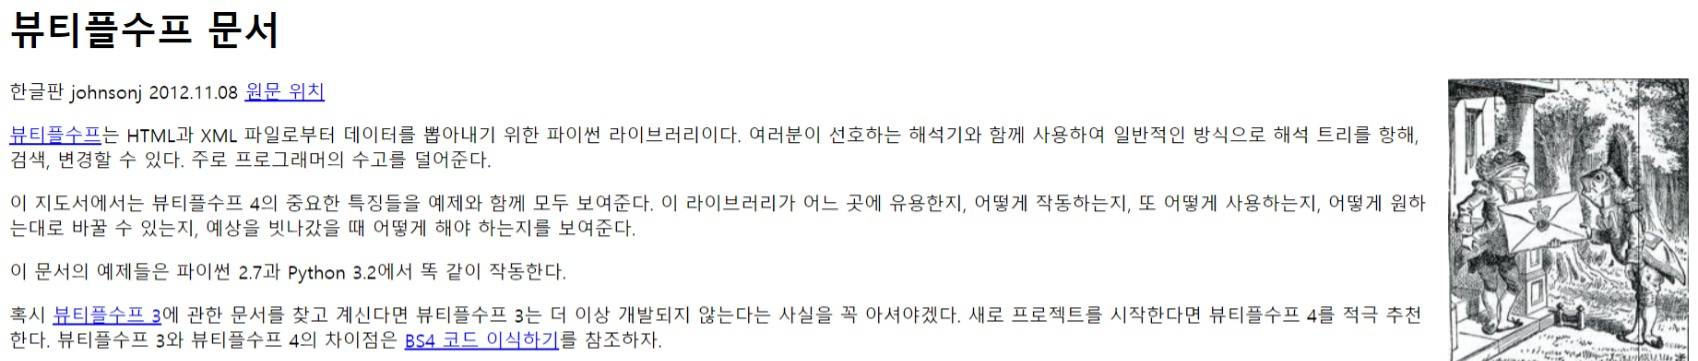

- 그 외에 닫힌 문자열 제거, 정규화사전을 이용한 데이터 정규화, 소유격 제거, 특수문자 제거, 의미없는 mmm 같은 단어 축약 등의 전처리 과정을 거지고 불용어를 제거해주었습니다.

In [11]:
from tqdm import tqdm

clear_head = []
clear_text = []

for sentence in tqdm(data['headlines']):
    clear_head.append(preprocess_sentence(sentence))

for sentence in tqdm(data['text']):
    clear_text.append(preprocess_sentence(sentence))

100%|██████████| 98360/98360 [07:58<00:00, 205.37it/s]


- 파이썬 진행률 프로그레스 바 라고 사용하는 tqdm을 사용하였습니다.
- 별다른 기능은 없고 현재 반복문의 진행률을 보여주는것인데 생각보다 함수를 이용한 데이터 전처리 과정이 꽤 길었기 때문에 tqdm을 적용하여 확인할수 있도록 하였습니다. 

In [14]:
print('원본 데이터 길이: ', len(data['text']))
print('전처리 후 텍스트 데이터 길이: ', len(clear_text))
print('전처리 후 요약 데이터 길이: ', len(clear_head))

원본 데이터 길이:  98360
전처리 후 텍스트 데이터 길이:  98360
전처리 후 요약 데이터 길이:  98360


- 처리 후 데이터의 길이는 변하지 않은것을 확인할 수 있습니다.

In [17]:
print('요약 데이터 0~4번 인덱스의 길이')
print('인덱스 0번의 길이: ', len(clear_head[0]))
print('인덱스 1번의 길이: ', len(clear_head[1]))
print('인덱스 2번의 길이: ', len(clear_head[2]))
print('인덱스 3번의 길이: ', len(clear_head[3]))
print('인덱스 4번의 길이: ', len(clear_head[4]))

요약 데이터 0~4번 인덱스의 길이
인덱스 0번의 길이:  48
인덱스 1번의 길이:  48
인덱스 2번의 길이:  59
인덱스 3번의 길이:  56
인덱스 4번의 길이:  45


In [16]:
print('텍스트 데이터 0~4번 인덱스의 길이')
print('인덱스 0번의 길이: ', len(clear_text[0]))
print('인덱스 1번의 길이: ', len(clear_text[1]))
print('인덱스 2번의 길이: ', len(clear_text[2]))
print('인덱스 3번의 길이: ', len(clear_text[3]))
print('인덱스 4번의 길이: ', len(clear_text[4]))

텍스트 데이터 0~4번 인덱스의 길이
인덱스 0번의 길이:  290
인덱스 1번의 길이:  269
인덱스 2번의 길이:  270
인덱스 3번의 길이:  241
인덱스 4번의 길이:  248


- 이제 데이터의 최대길이, 최소길이 등을 알아볼 생각인데 기준점이 될수 있는 길이를 획득하기위해 0~4번 인덱스까지의 길이를 알아보았습니다.

In [18]:
head_total_len = 0
text_total_len = 0
head_max_len = 0
text_max_len = 0
head_min_len = len(clear_head[0])
text_min_len = len(clear_text[0])

for s in range(len(clear_head)):
    if len(clear_head[s]) < head_min_len:
        head_min_len = len(clear_head[s])
        head_total_len += len(clear_head[s])   
    elif len(clear_head[s]) > head_max_len:
        head_max_len = len(clear_head[s])
        head_total_len += len(clear_head[s])     
    else:
        head_total_len += len(clear_head[s])
        
for s in range(len(clear_text)):
    if len(clear_text[s]) < text_min_len:
        text_min_len = len(clear_text[s])
        text_total_len += len(clear_text[s]) 
    elif len(clear_text[s]) > text_max_len:
        text_max_len = len(clear_text[s])
        text_total_len += len(clear_text[s])       
    else:
        text_total_len += len(clear_text[s])
        
        
head_mean_len = head_total_len/len(clear_head)
text_mean_len = text_total_len/len(clear_text)

print('헤드라인 데이터 문장 최대 길이: ', head_max_len)
print('텍스트 데이터 문장 최대 길이: ', text_max_len)
print('-----'*20)
print('헤드라인 데이터 문장 평균 길이: ', head_mean_len)
print('텍스트 데이터 문장 평균 길이: ', text_mean_len)
print('-----'*20)
print('헤드라인 데이터 문장 최소 길이: ', head_min_len)
print('텍스트 데이터 문장 최소 길이: ', text_min_len)
print('-----'*20)
print('헤드라인 데이터 문장 총 길이: ', head_total_len)
print('텍스트 데이터 문장 총 길이: ', text_total_len)

헤드라인 데이터 문장 최대 길이:  69
텍스트 데이터 문장 최대 길이:  374
----------------------------------------------------------------------------------------------------
헤드라인 데이터 문장 평균 길이:  46.778273688491254
텍스트 데이터 문장 평균 길이:  258.7241053273689
----------------------------------------------------------------------------------------------------
헤드라인 데이터 문장 최소 길이:  9
텍스트 데이터 문장 최소 길이:  4
----------------------------------------------------------------------------------------------------
헤드라인 데이터 문장 총 길이:  4601111
텍스트 데이터 문장 총 길이:  25448103


- 최대길이, 최소길이, 평균길이를 알아보았습니다. 잘 구해진듯 하군요

In [19]:
data['headlines'] = clear_head
data['text'] = clear_text

data.replace('', np.nan, inplace=True)

- 전처리한 데이터를 다시 데이터프레임으로 넣도록 하겠습니다.
- 전처리 과정중 발생한 공백은 nan값으로 채워주도록 하겠습니다.

In [20]:
data.isna().sum()

headlines    0
text         0
dtype: int64

- 공백을 nan으로 변환하였는데도 바뀐게 없군요. 전처리가 잘 된것같습니다.

In [21]:
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98360


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 374
텍스트의 평균 길이 : 258.7241053273689
요약의 최소 길이 : 9
요약의 최대 길이 : 69
요약의 평균 길이 : 46.778273688491254


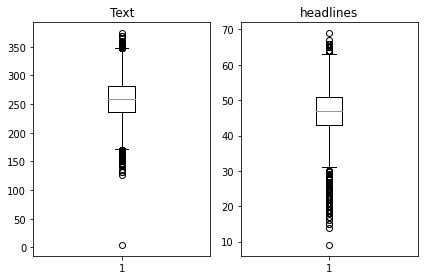

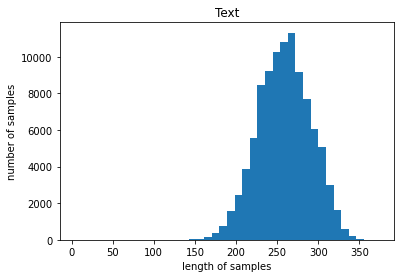

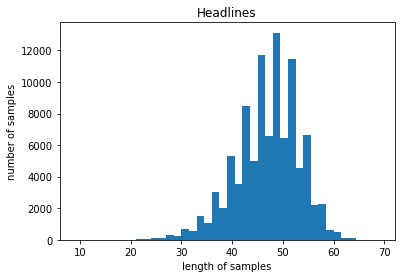

In [22]:
import matplotlib.pyplot as plt

text_len = [len(s) for s in data['text']]
head_len = [len(s) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(head_len)))
print('요약의 최대 길이 : {}'.format(np.max(head_len)))
print('요약의 평균 길이 : {}'.format(np.mean(head_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 위 그래프는 LMS에서 가져온 분포 그래프입니다. 제가 구한 문장 길이와 다르지 않군요. 그래프만 참고하도록 하겠습니다.

In [29]:
text_max = 300
head_max = 55

- 위 분포를 보고 적절한 값을 임의로 지정하였습니다.

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100),'%')

In [31]:
below_threshold_len(text_max, data['text'])
below_threshold_len(head_max,  data['headlines'])

전체 샘플 중 길이가 300 이하인 샘플의 비율: 89.91968279788532 %
전체 샘플 중 길이가 55 이하인 샘플의 비율: 94.0982106547377 %


- 해당 분포값의 비율을 알아보았습니다. 텍스트 데이터는 약 90%, 요약 데이터는 94% 정도 해당하는군요.

In [81]:
data = data[data['text'].apply(lambda x: len(x) <= text_max)]
data = data[data['headlines'].apply(lambda x: len(x) <= head_max)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 83773


- 위 분포를 기준으로 약 1만 5천개의 데이터가 삭제되었습니다. 이대로 진행하도록 하겠습니다.

---
## 2. 훈련 데이터셋 분리

In [33]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'start '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' end')
data.head()

headlines  \
0  upGrad learner switches career ML Al salary hike   
1  Delhi techie wins free food Swiggy one year CRED   
4     Have known Hirani yrs MeToo claims true Sonam   
6            India get lowest ODI total New Zealand   
7  Govt directs Alok Verma join work day retirement   

                                                text  \
0  Saurav Kant alumnus upGrad IIIT PG Program Mac...   
1  Kunal Shah credit card bill payment platform C...   
4  Speaking sexual harassment allegations Rajkuma...   
6  India recorded lowest ODI total New Zealand ge...   
7  Weeks ex CBI Director Alok Verma told Departme...   

                                       decoder_input  \
0  start upGrad learner switches career ML Al sal...   
1  start Delhi techie wins free food Swiggy one y...   
4  start Have known Hirani yrs MeToo claims true ...   
6       start India get lowest ODI total New Zealand   
7  start Govt directs Alok Verma join work day re...   

                                      decoder_target  
0  upGrad learner switches career ML Al salary hi...  
1  Delhi techie wins free food Swiggy one year CR...  
4  Have known Hirani yrs MeToo claims true Sonam end  
6         India get lowest ODI total New Zealand end  
7  Govt directs Alok Verma join work day retireme...

- 디코더에 start토큰과 end 토큰을 추가해주었습니다.

In [34]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

- 각각 입력과 레이블을 분리해 주었습니다.

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[14582 70687 12407 ... 53650 40027 39326]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 데이터의 정확성을 높이기 위해 셔플을 이용해 데이터의 순서만 수정하였습니다.
- 그렇다고 각각 인풋데이터와 레이블데이터의 인덱스는 섞이지 않습니다.

In [86]:
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('인코더 데이터의 개수 :', len(encoder_input_train))
print('디코더 데이터의 개수 :', len(decoder_input_train))
print('인코더 테스트 데이터의 개수 :', len(encoder_input_test))
print('디코더 테스트 데이터의 개수 :', len(decoder_input_test))

인코더 데이터의 개수 : 67019
디코더 데이터의 개수 : 67019
인코더 테스트 데이터의 개수 : 16754
디코더 테스트 데이터의 개수 : 16754


- 8:2 비율로 훈련 데이터셋과 벨리데이션 데이터셋을 분리해 주었습니다.
- 잘 구분 된것을 확인할 수 있습니다.

In [38]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- Tokenizer 함수를 이용해 인코더 인풋 데이터를 토큰화 해주었습니다.

In [39]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63531
등장 빈도가 8번 이하인 희귀 단어의 수: 45892
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17639
단어 집합에서 희귀 단어의 비율: 72.23560151736947
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.453557884658697


- 각 vocab_size를 채용하기 위해 단어의 빈도수 순으로 확인해 보았습니다.
- 많이 언급되는 단어들을 기준으로 vocab_size를 선택하였습니다.

In [40]:
src_vocab = 15000
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 위에선 약 17639개의 자주 언급되는 단어집합의 크기를 알려주지만 데이터이슈의 문제로 자꾸 오류가 나기에 15000개로 지정해주었습니다.

In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2264, 1870, 193, 22, 4464, 5, 570, 746, 1123, 91, 6203, 8016, 1566, 1855, 309, 1, 42, 1762, 3051, 160, 12, 4, 1870, 1718, 4706, 2838, 623, 38, 1123, 2, 3052, 2750, 423, 10376, 25, 2949], [46, 235, 610, 68, 314, 320, 5185, 5074, 2475, 2, 239, 601, 905, 235, 610, 2, 1311, 5185, 106, 235, 610, 384, 334, 13], [299, 6285, 3874, 58, 47, 275, 2212, 5304, 261, 6204, 780, 4885, 910, 275, 4503, 4885, 3092, 628, 3874, 275, 113, 3874, 5075, 978, 170, 1625, 3527, 3958, 189, 4632, 108, 275, 284, 219, 4885, 5075, 978, 246]]


- 토큰화가 잘 된 모습을 볼 수 있습니다.

In [42]:
tar_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [43]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27666
등장 빈도가 8번 이하인 희귀 단어의 수: 20385
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7281
단어 집합에서 희귀 단어의 비율: 73.68249837345479
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.014915886962891


- 디코더 데이터도 똑같이 분류해주었습니다.

In [44]:
tar_vocab = 6000
tar_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[2, 460, 43, 3222, 163, 634, 526, 1008, 215, 1482], [2, 293, 699, 112, 206, 2819, 3671], [2, 87, 2912, 3318, 537, 1009, 2382, 2989], [2, 1710, 5729, 635, 198, 49, 114, 1124, 49, 93], [2, 282, 399, 407, 602, 114, 1644, 28]]
target
decoder  [[460, 43, 3222, 163, 634, 526, 1008, 215, 1482, 1], [293, 699, 112, 206, 2819, 3671, 1], [87, 2912, 3318, 537, 1009, 2382, 2989, 1], [1710, 5729, 635, 198, 49, 114, 1124, 49, 93, 1], [282, 399, 407, 602, 114, 1644, 28, 1]]


- 약 7281개의 데이터 집합 크기를 보여주지만 역시나 데이터이슈로 6000개로 지정해주겠습니다.

In [45]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 67017
훈련 레이블의 개수 : 67017
테스트 데이터의 개수 : 16752
테스트 레이블의 개수 : 16752


- 위 과정에서 start토큰이 남게되는 경우가 있어 확인해보았습니다.
- start 토큰은 모든 문장에서 언급되니 자주 언급되는 1순위 단어입니다. 때문에 단어 길이가 1인 문장이 있는지 확인하고 그 문장은 start토큰으로 판단하여 삭제하겠습니다.
  
  
- 약 2개의 데이터가 생겼군요. 삭제해주겠습니다.

In [46]:
encoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_train, maxlen=text_max, padding='post')
encoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_test, maxlen=text_max, padding='post')
decoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_train, maxlen=head_max, padding='post')
decoder_target_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_train, maxlen=head_max, padding='post')
decoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_test, maxlen=head_max, padding='post')
decoder_target_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_test, maxlen=head_max, padding='post')

- maxlen은 아까 지정했던 적정 분포의 크기로 각각 지정해 주었고 패딩은 post에 지정하여 분류하였습니다.

---
## 3. 모델 설계하기

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim, mask_zero=True)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, activation = 'tanh', return_sequences=True, return_state=True ,dropout = 0.3)
encoder_output1, _, _ = encoder_lstm1(enc_emb)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, activation = 'tanh', return_sequences=True, return_state=True, dropout = 0.3)
encoder_output2, _, _ = encoder_lstm2(encoder_output1)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, activation = 'tanh', return_sequences=True, return_state=True, dropout = 0.3)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩층에 mask_zero 파라미터를 추가하여 패딩을 무시할 수 있도록 하였습니다.
- LSTM에서는 activation 함수로 tanh 즉 디폴트값을 선택하였습니다. 제가 여러가지 activation 함수를 이용하는것을 좋아하지만 이번에 깨달은게.. 있었습니다. 이는 후술하도록 하겠습니다.
- 또한 LSTM1 과 LSTM2 에서 state_h1, c1, state_h2, c2를 솔직히 왜 사용하는지 모르겠어서 제거하고 이용해보았습니다. 성능에 전혀 문제가 없더군요. 때문에 그래서 삭제하도록 하였습니다.

In [48]:
# 디코더 설계
decoder_inputs = Input(shape=(head_max,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim,mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, activation = 'tanh', return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 인코더의 layer와 동일하게 임베딩에 mask_zero를 추가하였고 특이점으론 디코더 아웃풋에서 인코더의 state_h, state_c를 initail_state로 사용하여 인코더의 정보를 이용할 수 있도록 하였습니다.

In [49]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55)]         0                                            
______________________________________________________________________________________________

- 타켓의 vocab_size만큼을 가진 softmax함수를 가진 출력층을 만들었습니다. 모델이 잘 생성이 되었군요.

---
## 3.1 어텐션 레이어 사용하기

In [50]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer', dropout=0.3)

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55)]         0                                            
____________________________________________________________________________________________

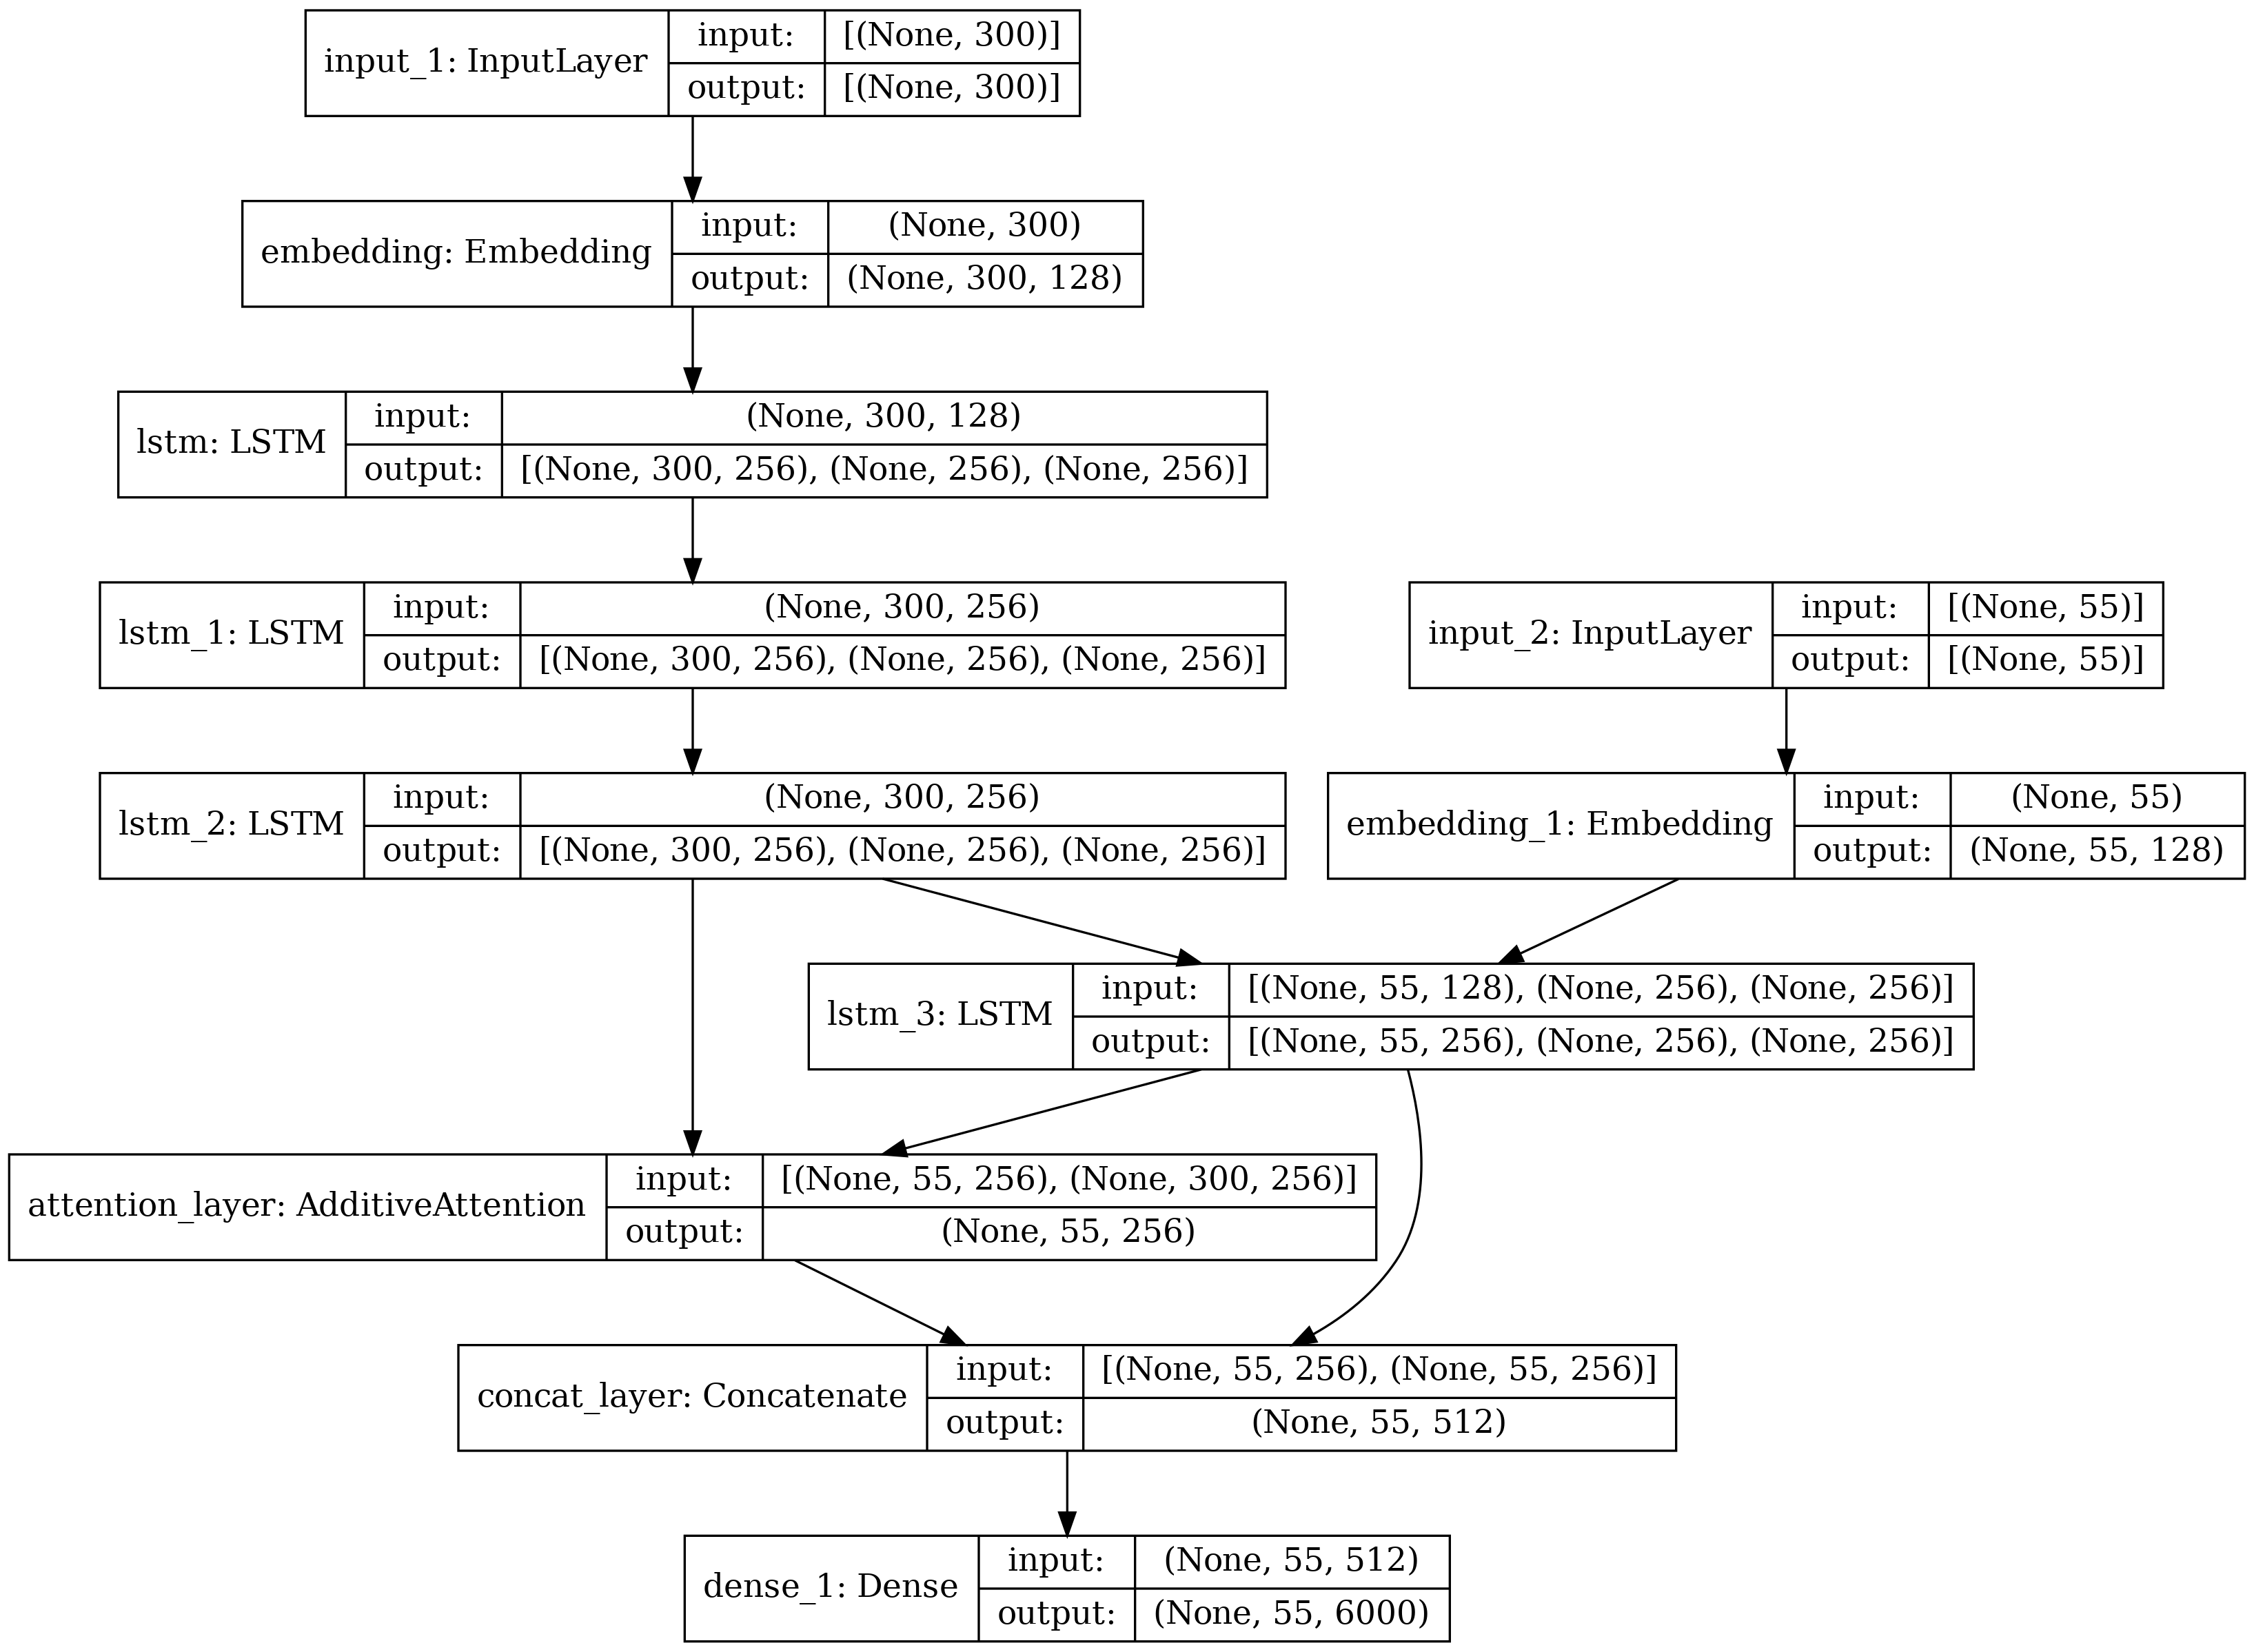

In [51]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=240)

- 어텐션이 잘 적용되었습니다.
### 어텐션 레이어란??

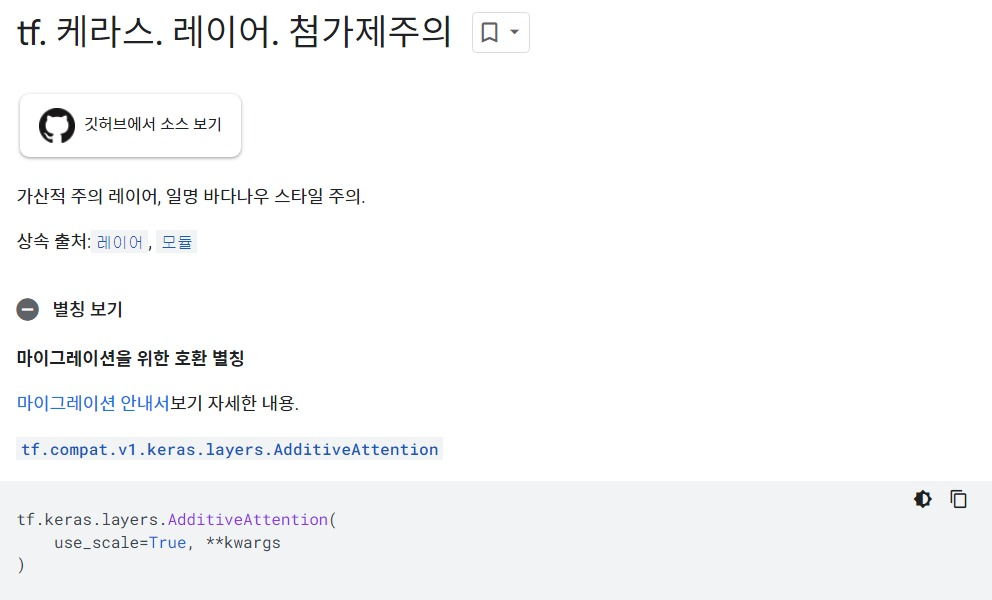

- 번역문을 돌렸더니 첨가제 주의란 말이 뜨는군요.. addtiveattention이랍니다.

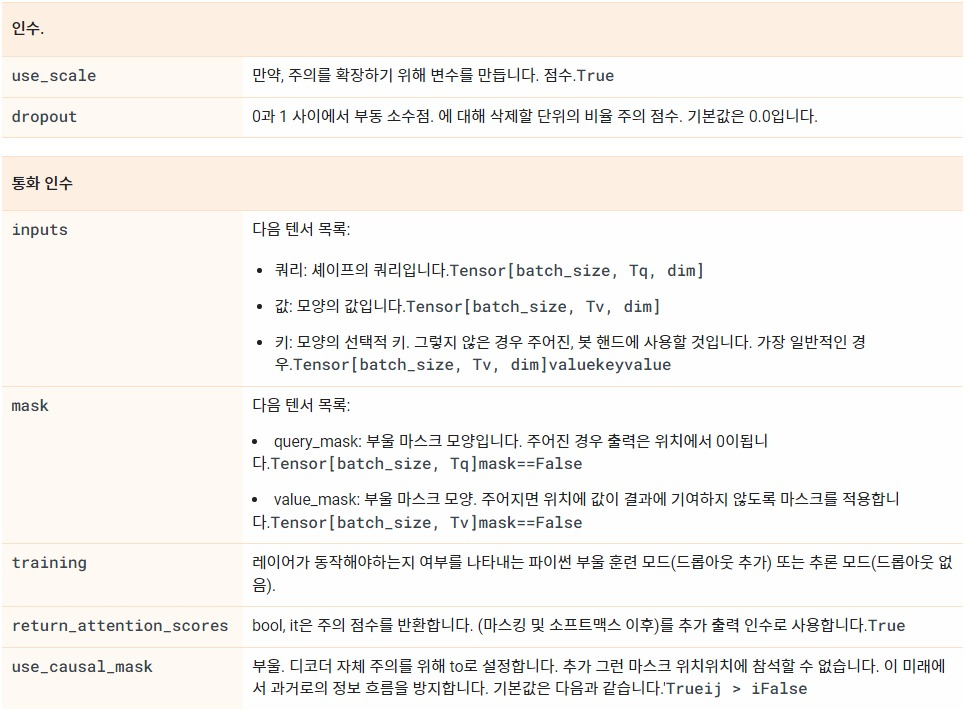

- 각 파라미터는 이렇습니다.

- 위 파라미터에서 mask를 사용해보고싶었지만.. 사용법을 도저히 찾을수 없었습니다. 때문에 dropout만 채용하여 사용하였습니다.
  
  
- 하지만 이정도만 봐서는 어텐션이 뭔지 잘 모르겠습니다. 어텐션은 무엇일까요?

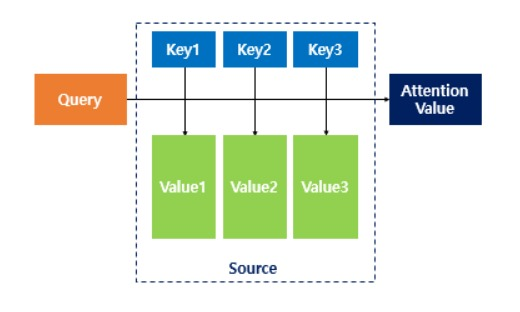

- 어텐션은 key, value, query 로 이루어진 쌍 데이터입니다.
   - 각각은 이렇습니다.
   - Q = Query : t 시점의 디코더 셀에서의 은닉 상태
   - K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
   - V = Values : 모든 시점의 인코더 셀의 은닉 상태들

- 위 그림과 같이 키와 쿼리간의 유사도를 구한 후 그 유사도가 더해진 값을 모두 리턴해 어텐션 밸류로 리턴합니다.
- 닷 프로덕트, 스케일 닷 프로덕트 등 여러가지 어텐션이 있지만 그것은 다음번에 서술하도록 하겠습니다.

- 자 이런 특징을 보았습니다. 여기서 또 하나의 의문점이 들었습니다.

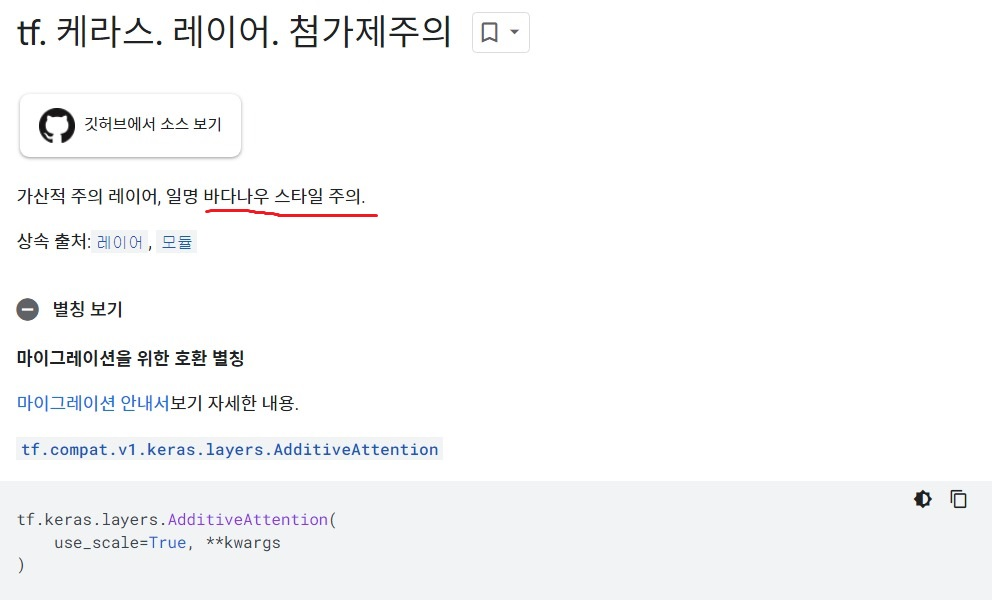

- 바다나우 스타일? 바다나우 스타일이 뭘까요?

#### 바다나우 스타일이란?

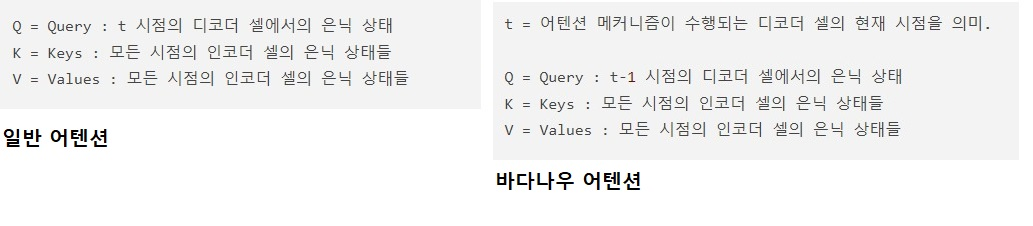

- 조금 차이가 있군요
- 어텐션 함수의 쿼리에 들어가는 t 시점이란것이 바다나우에선 t-1의 시점입니다. 이것이 무엇을 의미하는 걸까요?
- 내용이 상당히 어려워 제대로 이해하지 못해 설명이 힘들어 사진으로 첨부하겠습니다.

---
### 닷 프로덕트 어텐션
- 가장 수식적으로 이해 가능하다는 어텐션입니다. 바다나우와의 차이를 확인해보겠습니다.

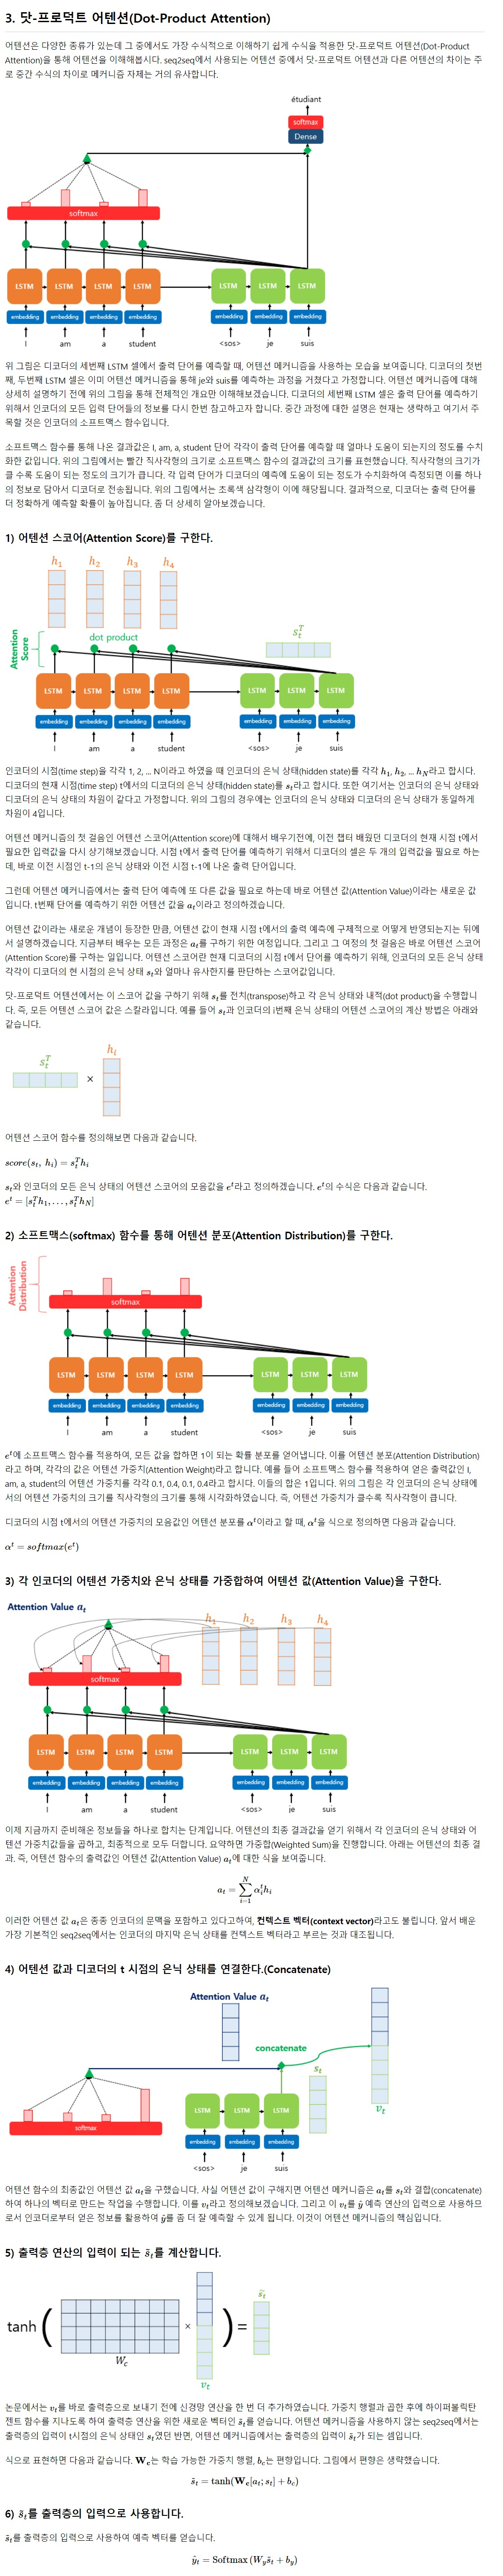

---
### 바다나우 어텐션  
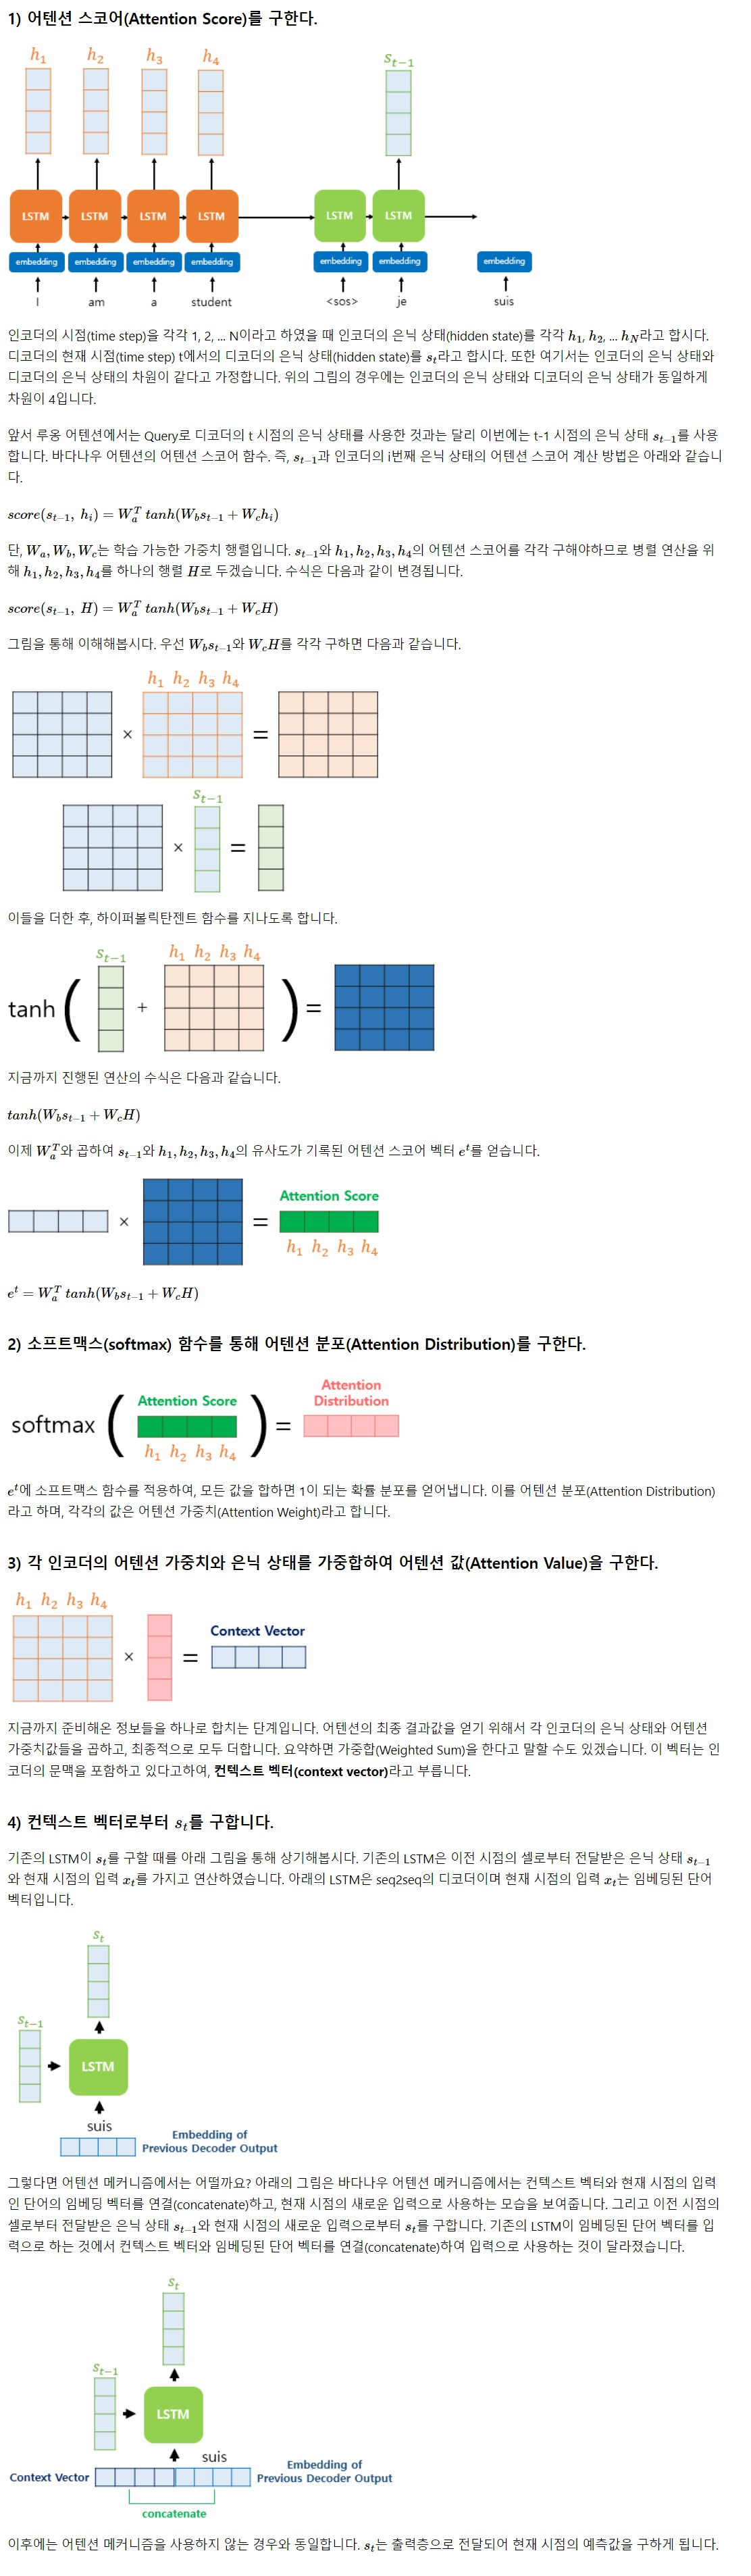

---
## 4. 모델 학습하기

In [52]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- 먼저 GPU를 사용 가능한지 확인해보았습니다. 사용 가능하군요!
- 학습을 시켜보도록 하겠습니다.

In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=64, callbacks=[es], epochs=50)

Epoch 1/50
1048/1048 [==============================] - 193s 151ms/step - loss: 0.8867 - val_loss: 0.8336
Epoch 2/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.8069 - val_loss: 0.7756
Epoch 3/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.7585 - val_loss: 0.7417
Epoch 4/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.7224 - val_loss: 0.7145
Epoch 5/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.6936 - val_loss: 0.6943
Epoch 6/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.6703 - val_loss: 0.6788
Epoch 7/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.6515 - val_loss: 0.6686
Epoch 8/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.6342 - val_loss: 0.6603
Epoch 9/50
1048/1048 [==============================] - 155s 148ms/step - loss: 0.6202 - val_loss: 0.6525
Epoch 10/50
1048/1048 [=======================

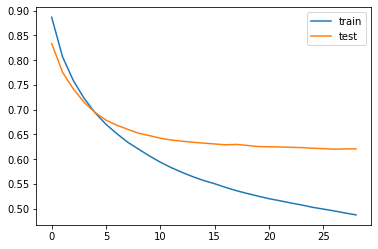

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 학습에선 optimizer로 rmsprop을 사용하였습니다. 
#### 왜 adam을 사용하지 않았는가? 에 대해 말씀드리겠습니다.
- 여기서도 adma을 사용하지 않았고 아까도 tanh가 아닌 relu, gelu 같은 다른 activation 함수를 이용하지 않은 점에대해 후술한다고 말씀드렸습니다.
- 가장 큰 문제로는 GPU 사용 불가에 있었습니다.

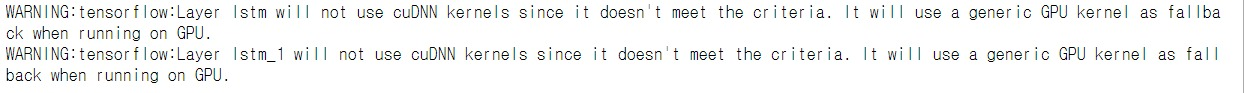


- 이러한 경고문구가 떴습니다. 번역하자면 다음과 같습니다.
- 경고:tensorflow:Layer lstm은 기준을 충족하지 않기 때문에 cuDNN 커널을 사용하지 않습니다. GPU에서 실행할 때 일반 GPU 커널을 폴백으로 사용합니다.
  
  
- 무슨의미였을까요.. 알아보니 단순하게 GPU를 사용하지 못한다는 이야기였습니다.
- 이게 얼마나 큰 문제를 일으키는지.. 그땐 몰랐습니다.. 학습을 시켜보았습니다.

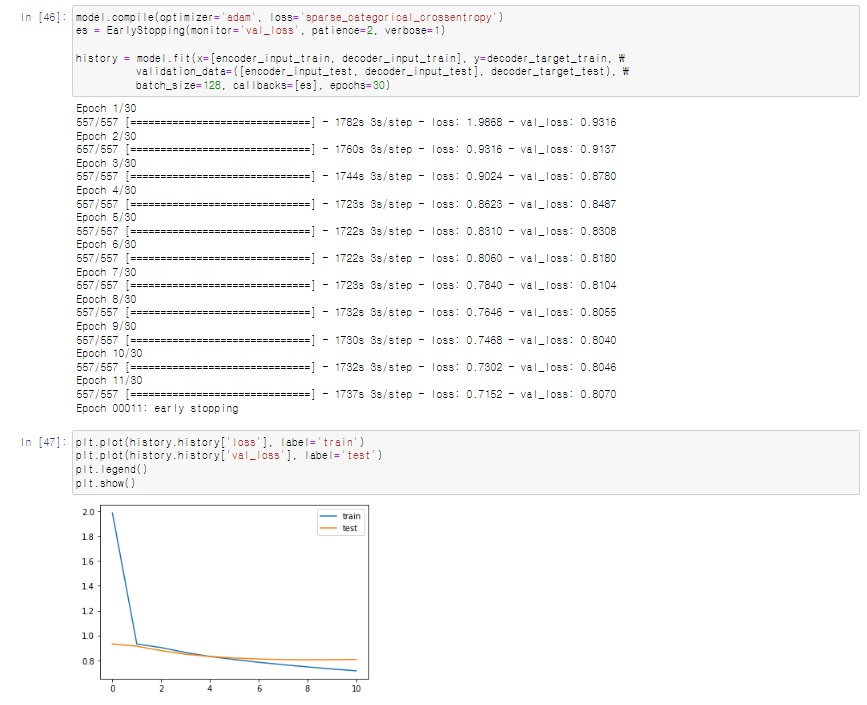

- 이렇게 오래걸릴줄.. 몰랐습니다...
- 약 318분, 약 5시간 18분 정도 걸렸습니다만... 히스토리 그래프도 처참하더군요.
- 그렇다면 성능은..?

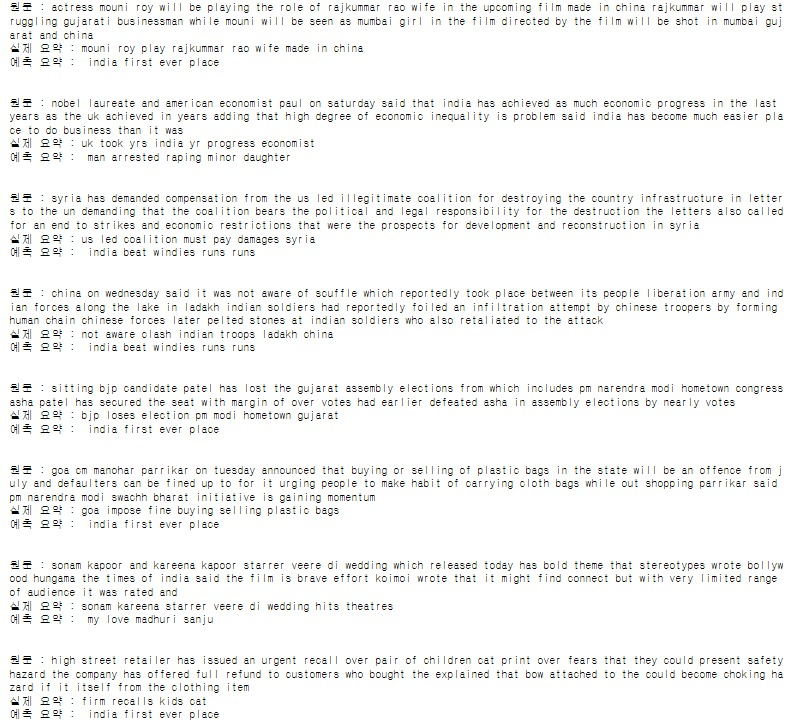

- 성능 또한 처참합니다. 도대체 무엇이 문제인지 자꾸 india를 찾습니다.. 추상적요약이 아닌 그냥 본인 생각만하는 모습을 보여줍니다.
- 따라서 relu, gelu, adam 을 포기하고 원점인 tanh와 rmsprop을 이용하여 진행하게되었습니다.

---
## 5. 추상적 요약을 통한 모델 검증

In [55]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [56]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [57]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max, hidden_size))
attn_out_inf = attn_layer([decoder_outputs, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h, state_c])

- 디코더 함수를 만들어주었습니다.
- 이전 신경망의 state_h, state_c를 이용하여 출력합니다.

In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (head_max-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['start']) and i!=tar_word_to_index['end']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- 출력 함수를 만들었습니다.
- 결과를 확인해보겠습니다.

In [75]:
for i in [3242, 8999, 3691,6543,6666]:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max)))
    print("\n")

원문 : four year old girl died monday two days sustaining burns face fell pan containing hot tea delhi old reportedly elder sister prepared tea kept bed waiting family members arrive girl fell bed landed head first pan 
실제 요약 : year old girl dies falling tea pan delhi 
예측 요약 :  year old girl dies get hit sharma


원문 : actress janhvi kapoor featured january cover magazine india she seen sporting wearing jacket amit aggarwal short tube dress the cover story janhvi titled would much rather think world she previously appeared cover vogue india 
실제 요약 : janhvi kapoor features january cover india 
예측 요약 :  janhvi kapoor shares picture


원문 : the madras high court tuesday reserved order plea actor dhanush seeking elderly couple lawsuit claiming son the court however gave date pronounce judgment the couple claimed dhanush schoolboy ran away chennai get film industry 
실제 요약 : hc reserves order dhanush plea claim 
예측 요약 :  no one handed catch post pic


원문 : india under world cup winning captain p

| index |실제 요약|실제 요약 번역|예측 요약|예측 요약 번역|
|------|--------------:|--------------------:|---------------------:|-------------------------:|
|3242|year old girl dies falling tea pan delhi|한 살짜리 소녀가 떨어지는 차 팬 델리에서 사망|year old girl dies get hit sharma|한 살짜리 소녀가 sharma에 맞아 사망|
|8999|janhvi kapoor features january cover india |janhvi kapoor 특집 1월 표지 인도|janhvi kapoor shares picture|janhvi kapoor 공유 사진|
|3691| hc reserves order dhanush plea claim |hc는 주문 dhanush 항변 청구를 준비합니다.|no one handed catch post pic|아무도 손을 대지 않은 캐치 포스트 사진|
|6543|virat kohli really guy prithvi shaw ahead debut |비랏 콜리 리얼 가이 프리스비 쇼 어드밴스드 데뷔| my one yr old girl debut film made|내 한 살짜리 소녀 데뷔 영화 제작|
|6666|pig world cup semi eating |돼지 월드컵 세미 먹는| year old girl takes part world cup|한 살짜리 소녀가 월드컵에 참가합니다.|

- 첫번째의 소녀 사망은 같으나 떨어지는 차와 sharma? 가 무엇인지 원문에도 sharma라는 단어는 등장하지않는데요. 여전히 성능이 애매합니다.
- 두번째의 표지, cover라는 단어와 picture의 어느정도 연관성은 보입니다. 나름 잘 된거같기도 하군요.
- 세번째는.. 볼것도 없습니다. 전혀 비슷하지 않습니다.
- 네번째 또한 데뷔라는 단어 말곤 비슷한 점이 없군요.
- 다섯번째 돼지 월드컵 세미 먹는? 월드컵은 같은데 애초에 돼지 월드컵 세미 먹는이 뭘까요..?
  
  
- 전체적으로 살펴봤으나 이는 데이터셋의 문제도 큰것같습니다. 제가 구글번역기를 너무 신뢰하는것인지 해석조차 되지 않는 원본도 많았구요. 요약은 더더욱 해석이 되지 않았습니다. 그래도 어느정도의 성능은 보여주는것 같군요

---
## 6. 추출적 요약

In [61]:
from summa.summarizer import summarize

- summa의 summarizer를 이용하여 추출적요약을 해보도록 하겠습니다.

#### summa란?

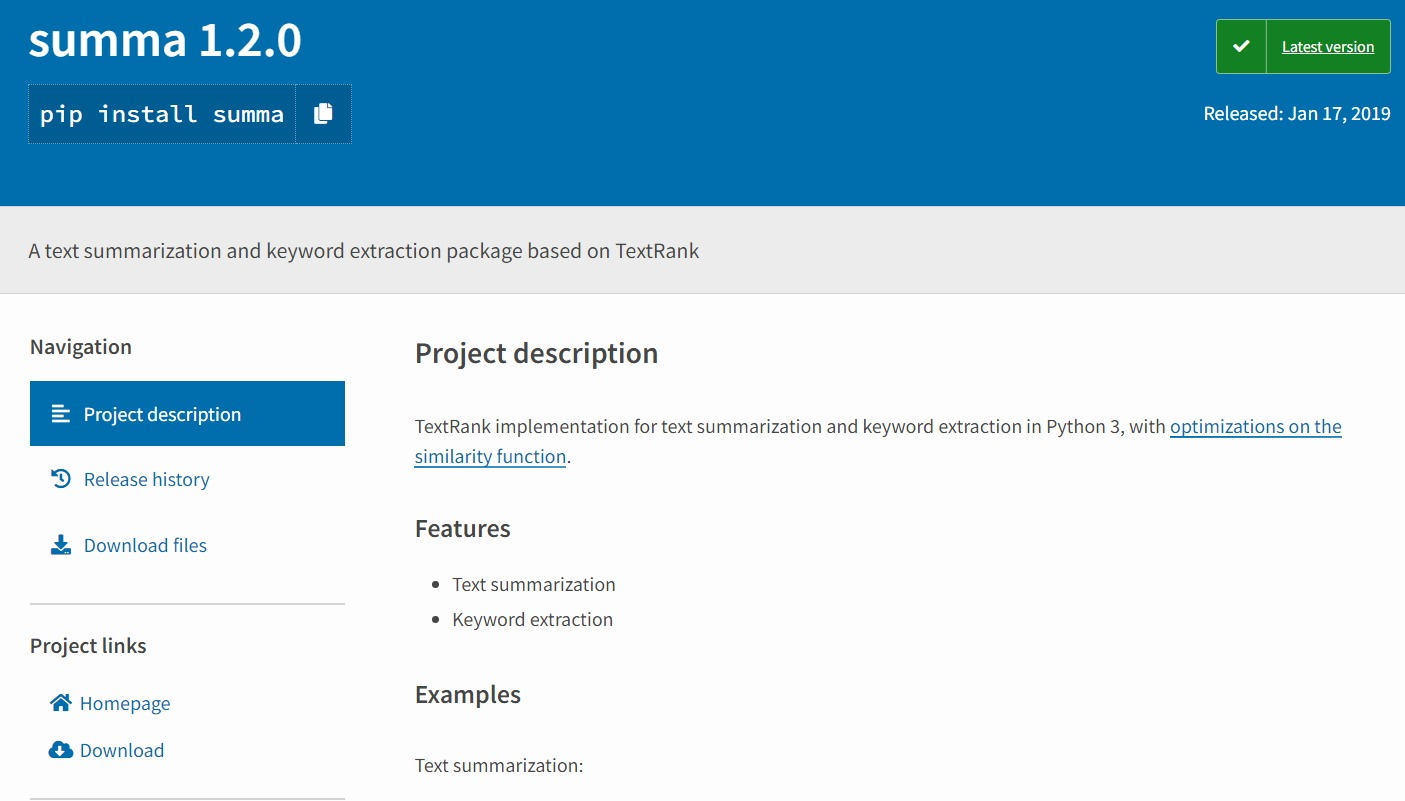

- 텍스트 요약과 키워드 추출이 주 목적인 모듈입니다.

#### summarize의 파라미터

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [62]:
data2 = pd.read_csv(file_path, encoding='UTF-8')

- 전처리된 데이터가 아닌 원본 데이터를 가져오곘습니다.
- 여기선 인코딩에 대해서도 살짝 맛보기로 공부를 조금 해보았습니다.
- LMS 에선 iso-8859-1 로 불러오는데 왜 그럴까? 생각이 들어 UTF-8로 불러오고 이유를 알아보았습니다.

#### UTF
- UTF 는 최대 2 ^ 31 [약 20 억] 문자를 나타낼 수있는 유니 코드 코드 포인트를 나타낼 수있는 멀티 바이트 인코딩 체계입니다 . UTF-8 은 1 ~ 4 바이트를 사용하여 첫 2 ^ 21 [약 2 백만] 코드 포인트를 나타내는 유연한 인코딩 시스템입니다.

- 간단히 말해 : 7 비트 안전 ASCII라고하는 127 이하의 코드 포인트 / 소수점 표현을 가진 문자는 대부분의 다른 1 바이트 인코딩과 동일한 1 바이트 시퀀스로 표시됩니다. 코드 포인트가 127 이상인 모든 문자는 2 바이트 이상의 시퀀스로 표시되며 여기 에서 인코딩에 대한 설명이 가장 좋습니다 .

#### ISO-8859
- ISO-8859 는 127에서 255 사이의 범위에서 표현 될 수있는 알파벳을 나타내는 데 사용되는 단일 바이트 인코딩 체계입니다. 이러한 다양한 알파벳은 가장 익숙한 ISO-8859- n 형식의 "부분"으로 정의됩니다. 이것은 아마도 ISO-8859-1 일명 '라틴 -1'일 것입니다. UTF-8과 마찬가지로 7 비트 안전 ASCII는 사용 된 인코딩 제품군에 관계없이 영향을받지 않습니다.

- 이 인코딩 체계의 단점은 128 개 이상의 기호로 구성된 언어를 수용 할 수 없거나 한 번에 두 개 이상의 기호 계열을 안전하게 표시 할 수 없다는 것입니다. 또한 ISO-8859 인코딩은 UTF의 등장으로 호의를 얻지 못했습니다. 2004 년에 해체 된 책임을 맡고있는 ISO "작업반 (Working Group)"은 부모 소위원회까지 유지 보수를 맡겼습니다.
  
  
- 라고 합니다만.. 하지만 
- ISO-8859-1은 1980 년대의 레거시 표준입니다. 256 자만 표현할 수 있으므로 서구의 일부 언어에만 적합합니다. 지원되는 많은 언어의 경우에도 일부 문자가 누락되었습니다. 이 인코딩으로 텍스트 파일을 작성하고 일부 한자를 복사 / 붙여 넣기를 시도하면 이상한 결과가 나타납니다. 즉, 사용하지 마십시오. 유니 코드는 전 세계를 장악했으며 UTF-8은 모든 레거시와 호환되어야하는 HTTP 헤더와 같은 레거시 이유가 없다면 요즘 거의 표준입니다.

- UTF-8이 표준이라고 하는군요. 또한 iso-8859-1이 latin-1이라는것을 알게되었습니다. 왜 이게 저한테 중요하냐면 예전에 latin-1 오류때문에 골치아픈적이 있어서 생각이 납니다. 그땐 지금보다 서칭실력이 모자라서 못알아봤지만 이제는 알 수 있을것 같습니다.
  
  
- 하지만 문제는.. 여전히 왜 ISO-8859-1로 불러왔을까요? 이유는 찾지못했습니다..

In [63]:
data2['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

- 잘 불러와졌군요.

In [82]:
print('원본 텍스트: ', data2['text'][0])
print('-----'*25)
print('원본 요약 텍스트: ', data2['headlines'][0])
print('-----'*25)
print('추출적 요약 텍스트: ', summarize(data2['text'][0], ratio=0.005, words=15))

원본 텍스트:  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
-----------------------------------------------------------------------------------------------------------------------------
원본 요약 텍스트:  upGrad learner switches to career in ML & Al with 90% salary hike
-----------------------------------------------------------------------------------------------------------------------------
추출적 요약 텍스트:  upGrad's Online Power Learning has powered 3 lakh+ careers.


In [83]:
print('원본 텍스트: ', data2['text'][32])
print('-----'*25)
print('원본 요약 텍스트: ', data2['headlines'][32])
print('-----'*25)
print('추출적 요약 텍스트: ', summarize(data2['text'][32], words=15))

원본 텍스트:  Silvia Grecco, a 56-year-old Brazilian mother narrates her local football team Palmeiras' matches live to her 12-year-old blind and autistic son Nickollas from the stands. "I describe details: this player is wearing short sleeves...colour of...football boots, hair colour...Everything I see and feel, I tell him, even when I need to curse the referee!" Grecco said after a recent match.
-----------------------------------------------------------------------------------------------------------------------------
원본 요약 텍스트:  Brazilian mother narrates football matches to blind son from stands
-----------------------------------------------------------------------------------------------------------------------------
추출적 요약 텍스트:  Silvia Grecco, a 56-year-old Brazilian mother narrates her local football team Palmeiras' matches live to her 12-year-old blind and autistic son Nickollas from the stands.


In [84]:
print('원본 텍스트: ', data2['text'][10922])
print('-----'*25)
print('원본 요약 텍스트: ', data2['headlines'][10922])
print('-----'*25)
print('추출적 요약 텍스트: ', summarize(data2['text'][10922], words=15, split=True))

원본 텍스트:  Bhajan singer Vinod Agarwal, who gave over 1,500 live performances both in India and abroad, died aged 63 in Uttar Pradesh's Mathura on Tuesday. Agarwal was admitted to a hospital after complaining of chest pain on Monday and was put on life support after his vital organs stopped functioning. He was born in Delhi and had relocated to Vrindavan.
-----------------------------------------------------------------------------------------------------------------------------
원본 요약 텍스트:  Bhajan singer Vinod Agarwal, credited with 1500 events, dies at 63
-----------------------------------------------------------------------------------------------------------------------------
추출적 요약 텍스트:  ["Bhajan singer Vinod Agarwal, who gave over 1,500 live performances both in India and abroad, died aged 63 in Uttar Pradesh's Mathura on Tuesday."]


In [85]:
print('원본 텍스트: ', data2['text'][3822])
print('-----'*25)
print('원본 요약 텍스트: ', data2['headlines'][3822])
print('-----'*25)
print('추출적 요약 텍스트: ', summarize(data2['text'][3822], words=15))

원본 텍스트:  The US has officially quit the United Nations Educational, Scientific and Cultural Organisation (UNESCO), accusing the UN agency of "anti-Israel bias". The US had notified UNESCO of its decision to quit the organisation in October 2017 and had called for its "fundamental reform". Israel followed the US in quitting UNESCO. 
-----------------------------------------------------------------------------------------------------------------------------
원본 요약 텍스트:  US formally quits UNESCO over 'anti-Israel bias'
-----------------------------------------------------------------------------------------------------------------------------
추출적 요약 텍스트:  The US has officially quit the United Nations Educational, Scientific and Cultural Organisation (UNESCO), accusing the UN agency of "anti-Israel bias".


|index|원본 요약|원본 요약 해석|추출적 요약|추출적 요약 해석|
|---|---|---|---|---|
|0|upGrad learner switches to career in ML & Al with 90% salary hike|upGrad 학습자가 90% 급여 인상과 함께 ML 및 Al에서 경력으로 전환|upGrad's Online Power Learning has powered 3 lakh+ careers.|upGrad의 온라인 파워 러닝은 30만 이상의 경력을 쌓았습니다.
|32|Brazilian mother narrates football matches to blind son from stands|브라질 어머니, 관중석에서 맹인 아들에게 축구 경기 해설|Silvia Grecco, a 56-year-old Brazilian mother narrates her local football team Palmeiras' matches live to her 12-year-old blind and autistic son Nickollas from the stands.|56세의 브라질 어머니인 실비아 그레코(Silvia Grecco)는 자신의 지역 축구팀인 팔메이라스(Palmeiras)의 경기를 관중석에 있는 12세의 맹인 및 자폐증 아들 니콜라스(Nickollas)에게 생중계합니다.|
|10922|Bhajan singer Vinod Agarwal, credited with 1500 events, dies at 63|1,500번의 행사를 가진 바잔의 가수 비노드 아가르왈, 63세로 별세|["Bhajan singer Vinod Agarwal, who gave over 1,500 live performances both in India and abroad, died aged 63 in Uttar Pradesh's Mathura on Tuesday."]|["인도와 해외에서 1,500회 이상의 라이브 공연을 한 바잔 가수 Vinod Agarwal이 화요일 Uttar Pradesh의 Mathura에서 63세의 나이로 사망했습니다."]|
|3822| US formally quits UNESCO over 'anti-Israel bias'|미국, '반이스라엘 편견' 이유로 유네스코 공식 탈퇴| The US has officially quit the United Nations Educational, Scientific and Cultural Organisation (UNESCO), accusing the UN agency of "anti-Israel bias".|미국이 유엔 기구를 "반이스라엘 편향"이라고 비난하며 유엔 교육 과학 문화 기구(UNESCO)에서 공식적으로 탈퇴했습니다.|

- 추출적 요약에선 그래도 괜찮은 성능을 보여줍니다. 추상적 요약처럼 말도 안되는 해석을 보여주진 않는군요. 역시 무난한게 제일이라고.. 하는 이유를 알듯합니다.

---
## 7. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트는 성능내기가 가장 힘들었습니다. 너무 추상적 요약에서 너무 결과물이 안나오다보니 다시하고 수정하고 다시하고 전처리부터 하고 모두 해보고 overfitting도 심하게 나기에 dropout도 수정하고 여러가지 시도를 해보았지만 결과적으로 결국 성능은 안좋게 끝이 났습니다. 성능 끌어올리기가 가장 힘들었습니다.

### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트에서는 학습한 내용이 상당히 많았습니다. 그동안 자세히 안봤던 UTF-8, iso-8859-1 같은 인코딩 방식도 알아보았고 특히 attention layer에 대해 알아보게 되었습니다. 앞으로 많이 사용하게 될텐데 지식을 좀 다잡고 가야할듯하다고 생각합니다.

### 알아낸 점이나 모호한 점
>- attention layer에 관해 가장 많이 알게되었고 여전히 가장 모호하다고 생각합니다. 정확한 메커니즘이 이해되진 않고 seq2seq 과정중 LSTM의 state가 어떻게 작용하는지 아직 모호합니다. 특히 GRU를 이용해 시도해보고 싶었지만 state의 갯수가 달라 적용하지 못했고 tokenizer 함수가 아닌 TextVectorization 을 이용해 보고싶었으나 역시나 활용법이 모호하여 아직 사용하지 못했습니다. 다음번엔 이용해볼 수 있도록 하겠습니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.__ 에 대해서는 데이터 전처리 과정 중 정규화 사전을 이용하였고 불용어를 삭제하였고 데이터셋 분리도 80%, 20% 비율로 분리하였으며 인코딩 또한 잘 진행되었다고 판단합니다.
>- __2. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.__ 요약문에 핵심단어.. 라고 하기엔 많이 애매합니다만 어느정도 포함하고 있는 모습은 보여주고 있습니다. loss 그래프 또한 우하향하는 그래프를 보여주고있으나 완벽하게 overfitting 을 해결하지 못해 여전히 어느정도의 loss가 정체되는 모습을 보여주고 있기도 합니다만 dropout 등을 이용해 overfitting을 해결할 수 있도록 노력하였습니다.
>- __3. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.__ 각 요약에 대해서 마크다운 표 형식을 이용해 분석 결과를 표로 정리하여 제시하였습니다. 생각보다 처음 써본 마크다운 표형식이 어려웠습니다. 문법적으로 어렵진 않았으나 무언가 헷갈리고 은근히 손이 많이가는 형식인것 같습니다.
### 루브릭 평가지표를 달성하지 못했다면 이유
>- 평가지표를 달성하지 못했다면 2번 루브릭때문이지 않을까 싶습니다. 확실한 성능 향상을 이끌어내지 못했고 그로 인해 핵식 단어 추출에 어려움을 겪었습니다. 때문에 2번 루브릭의 __핵심 단어들이 요약 문장 안에 포함되었다__ 라는 구절을 정확히 해결하지 못했기 때문이라고 생각됩니다.

---
## 8. Refenrence

- https://procodes.tistory.com/890 utf-8, iso-8859-1 의 관한 블로그
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html?- pd_read_csv 공식문서
- https://wikidocs.net/24996 seq2seq
- https://wikidocs.net/22893 attention mechanism
- https://wikidocs.net/73161 바다나우 어텐션
- https://www.crummy.com/software/BeautifulSoup/bs4/doc.ko/ beautiful soup 공식문서
- https://blog.naver.com/parksh1618/222827250361 tqdm 블로그
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention tf.addtiveattention 공식문서
- https://pypi.org/project/summa/ summa 공식문서

---
## 9. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 생각보다 어려웠습니다. 특히 성능 개선에서 가장 어려움을 겪었고 앞으로 NLP를 선택하여 이런 공부를 많이 하게 될텐데 이런 간단한 프로젝트에서도 성능을 이끌어내지 못한점이 좀 실망스러웠습니다. 지금까지 그래도 잘하고있었다고 생각했습니다만 이번 프로젝트를 통해 너무 자만하고 안일하면 안되겠다고 생각했습니다.
  
  
- 이번 프로젝트에서 아쉬웠던 점은 성능을 이끌어내지 못한점 빼고는 없습니다. 많이 안일했고 그로 인해 이러한 결과를 보여드린것 같습니다.
  
  
- 이제 다음주부터 방학인데 방학동안 좀 더 공부하고 혼자서도 이런 프로젝트를 만들수 있도록 연습해봐야겠다는 생각이 듭니다.